# Analysis and visualization of 3D data in Python

Daniela Ushizima, Alexandre de Siqueira, Stéfan van der Walt

_BIDS @ University of California, Berkeley_

_Lawrence Berkeley National Laboratory - LBNL_

* Support material for the tutorial _Analysis and visualization of 3D data in Python_.

This tutorial will introduce how to analyze three dimensional stacked and volumetric
images in Python, mainly using scikit-image. Here we will learn how to:
  * pre-process data using filtering, binarization and segmentation techniques.
  * inspect, count and measure attributes of objects and regions of interest in the data.
  * visualize 3D data.

Please prepare for the tutorial by [installing the pre-requisite
software](preparation.md) beforehand.

For more info:
  * [[ISVC 2019]](https://www.isvc.net/)
  * [[scikit-image]](https://scikit-image.org/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from skimage import io

In [3]:
input_filename="../data/bead_pack_artifacts_small.tif"
img = io.imread(input_filename)

In [ ]:
# uncomment if using Google colaboratory
#!wget https://github.com/dani-lbnl/imagexd19/blob/master/dip/data/bead_pack.tif?raw=true

In [ ]:
#!mv bead_pack.tif?raw=true bead_pack.tif

In [ ]:
#!ls *.tif

In [ ]:
#img = io.imread('bead_pack.tif')

## Basic image summary

In [4]:
print('* Shape: '+str(img.shape))
print('* Type: ' +str(img.dtype))
print('* Range: '+str(img.min())+','+ str(img.max()))

* Shape: (200, 200, 200)
* Type: uint8
* Range: 29,239


## Skim through

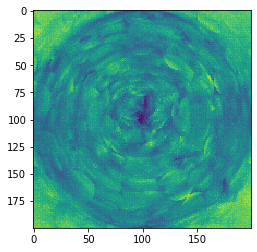

In [5]:
# Max projection is a fast way to pick on your stack content globally
x,y,z = img.shape
IM_MAX = img[0,:,:]
for n in np.arange(1,x):
    IM_MAX = np.maximum(IM_MAX, img[n,:,:])
plt.imshow(IM_MAX)    

In [9]:
#View each slice of original stack

from ipywidgets import interact,IntSlider

downsample = 1 #change to larger number if image shape > 1k 

def slicer(z):
    plt.imshow(img[z,::downsample,::downsample], cmap='gray', vmin=np.min(b), vmax=np.max(img))

interact(slicer, z=IntSlider(min=0, max=len(img), step=1, value=len(img)//2));

interactive(children=(IntSlider(value=100, description='z', max=200), Output()), _dom_classes=('widget-interac…

We will use the function slicer several times, so then let's create a way to quickly call it:

In [61]:
def slicing(b,lut='viridis'):
    def slicer(z):
        plt.imshow(b[z,:,:],cmap=lut)
    interact(slicer, z=IntSlider(min=0,max=len(b)-1,step=1,value=len(b)//2));

## Exercise: non-uniform background
- calculate the mean projection
- create a background subtraction function that uses mean projection

## Is the intensity distribution bimodal? 

In [23]:
from skimage.util import img_as_ubyte
from skimage import data
from skimage.exposure import histogram


def seeHistSlice(img,nslice):
    noisy_image = img_as_ubyte(img[nslice,:,:])
    hist, hist_centers = histogram(noisy_image)
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

    ax[0].imshow(noisy_image, cmap=plt.cm.gray, vmin=0, vmax=np.max(img))
    ax[0].set_title('Slice at the middle of the stack')
    ax[0].axis('off')

    ax[1].plot(hist_centers, hist, lw=2)
    ax[1].set_title('Histogram of grey values')
    ax[1].grid()

    plt.tight_layout()
    

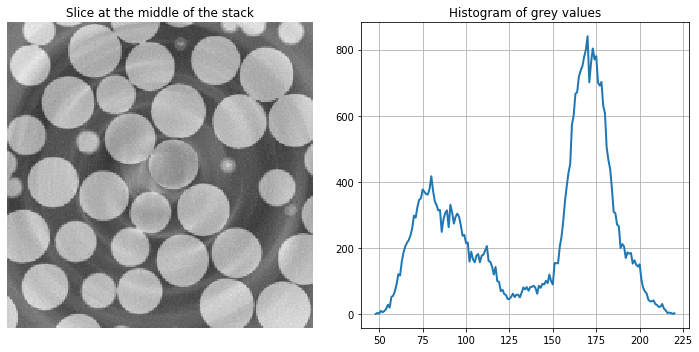

In [24]:
#Change nslice
nslice = len(img)//2 
seeHistSlice(img,nslice)

Now let's put a scroll bar to visualize stack

In [25]:
def slicingHist(b):
    def slicer(z):
        seeHistSlice(b,z)
    interact(slicer, z=IntSlider(min=0,max=len(b)-1,step=1,value=len(b)//2));    

In [26]:
slicingHist(img)

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

## Adjust exposure
- skimage.exposure.cumulative_distribution(image) 
- skimage.exposure.equalize(*args, **kwargs) 
- skimage.exposure.equalize_adapthist(image[, ...]) 
- skimage.exposure.equalize_hist(image[, nbins]) 
- skimage.exposure.histogram(image[, nbins]) 
- skimage.exposure.rescale_intensity(image[, ...]) 

In [28]:
#Equalization for volume data, although you might be skiming through your data 
from skimage import exposure
a = exposure.equalize_hist(img)
slicing(a,'gray')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

The Laplace operator or Laplacian is a differential operator given by the divergence of the gradient of a function on Euclidean space. In a Cartesian coordinate system, the Laplacian is given by the sum of second partial derivatives of the function with respect to each independent variable.

In [35]:
#Find the edges of an image using Laplacian
from skimage import filters as fi
img2 = fi.laplace(img)
slicing(img2,'gray')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

## Exercise: use other filters
- Explore [[skimage.filters.rank]](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html?highlight=rank#module-skimage.filters.rank) and apply to the 3D stack

In [36]:
# Exercise
from skimage.filters.rank import mean_bilateral
from skimage.morphology import disk

bilat = np.empty_like(img)
for i, aslice in enumerate(img):
    bilat[i] = mean_bilateral(aslice.astype(np.uint8), disk(3), s0=15, s1=15)   
    
slicing(img,'gray')    

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [37]:
# Exercise
from skimage.filters.rank import enhance_contrast

contr = np.empty_like(img)
for i, aslice in enumerate(img):
    contr[i]= enhance_contrast(aslice.astype(np.uint16),disk(3))
slicing(contr,'gray')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

# Scipy ndimage
- Multi-dimensional image processing
- https://docs.scipy.org/doc/scipy/reference/ndimage.html

In [39]:
#Let's run a median filter on our stack
from scipy import ndimage as ndi
from skimage.morphology import ball

aball = ball(radius=2) #3D structure element
median = ndi.median_filter(img,footprint=aball) 

In [41]:
slicing(median,'gray')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

## Exercise other functions
- Check [[ndimage]](https://docs.scipy.org/doc/scipy/reference/ndimage.html)
- Apply a rigid body transformation to a slice??
- 

# Segmentation

See slice: 100


(<Figure size 1152x720 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x116473898>,
       dtype=object))

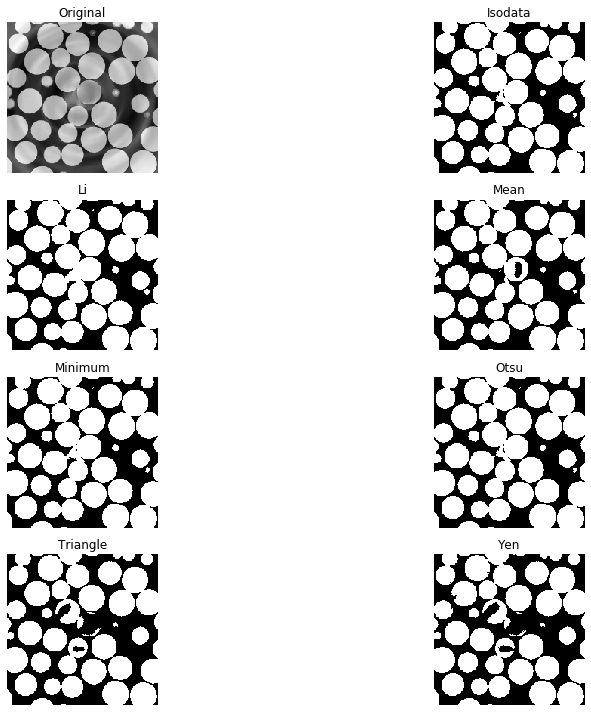

In [42]:
# checking the middle of the stack
n=len(img)//2 #middle
print("See slice: " + str(n))
aslice = bilat[n,:,:]
fi.try_all_threshold(aslice, figsize=(16,10), verbose=False)

In [44]:
# back to the full tack
t=fi.threshold_isodata(bilat)
binary = bilat>t

slicing(binary,'gray')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [54]:
def slicingMask(orig,binary):
    def slicer(z):
        plt.imshow(orig[z,:,:]*binary[z,:,:],cmap='gray',vmin=0, vmax=np.max(orig))
    interact(slicer, z=IntSlider(min=0,max=len(orig)-1,step=1,value=len(orig)//2));    

In [56]:
# masking
slicingMask(img,binary)

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

## Exercises:
- Create a labeled stack and output the number of connected component
- Slide between slice 68 and 69: how to fix it??
- Create a function that returns the largest connected component from a stack

In [62]:
from skimage.measure import label
labeled = label(binary.astype('int'),connectivity=2)
print(np.max(labeled))

27


In [63]:
slicing(labeled,'jet')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [65]:
# %load solutions/02_solution01_c.py

def getLargestCC(segments):
        '''Return a mask corresponding to the largest object'''
        labels = label(segments.astype('int'),connectivity=1)
        largestCC = labels == np.argmax(np.bincount(labels.flat, weights=segments.flat))
        return largestCC

a=getLargestCC(binary)

print('Volume largest obj: '+str(np.count_nonzero(a)))
print('Volume dense phase: '+str(np.count_nonzero(binary)))


Volume largest obj: 4994428
Volume dense phase: 4994615


# Clean up binary representation 

In [66]:
from skimage import morphology
aball = morphology.ball(radius=5) #aggressive

In [67]:
#3D Mathematical morphology
bin_e=morphology.binary_erosion(binary,selem=aball)
bin_o=morphology.binary_opening(binary,selem=aball)

In [68]:
#show two 2D images side by side for quick comparison
def imshowcmp(before,after,lut):
    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(before,cmap=lut)
    ax[1].imshow(after,cmap=lut)

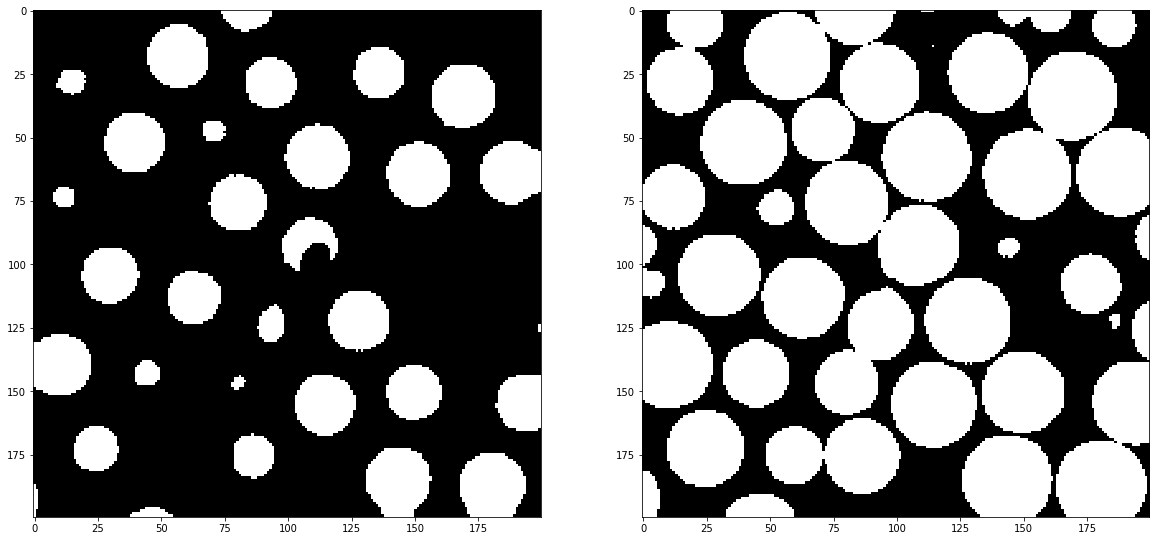

In [69]:
imshowcmp(bin_e[n,:,:],bin_o[n,:,:],'gray')

In [70]:
binary=bin_e

In [71]:
labeled = label(binary.astype('int'),connectivity=2)
print(np.max(labeled))

slicing(labeled,'rainbow')
#do not fully trust what you see here

299


interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

## Remove small objects

In [125]:
cleaned = morphology.remove_small_objects(binary, min_size=5000, connectivity=1, in_place=False)

labeled = label(cleaned,connectivity=2)
print(np.max(labeled))


204


## Fill holes

In [126]:
cleaned = morphology.remove_small_holes(cleaned, area_threshold=100, connectivity=1, in_place=True)
labeled = label(cleaned,connectivity=2)
nobjects = np.max(labeled)
print(nobjects)

204


In [127]:
slicing(labeled,'rainbow')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [128]:
# How to get a single object using labeled data?

loc = ndi.find_objects(labeled==50)[0]
bead = binary[loc]
bead.shape
np.sum(bead)

8761

## Exercise:
- Create a graph where x=label number and y=volume of bead in pels
- Estimate the number of beads

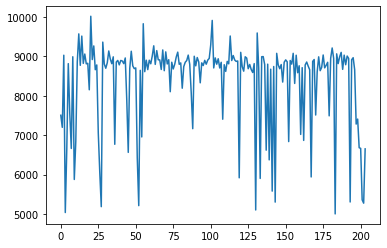

In [137]:
allBeads = ndi.find_objects(labeled)
accum = np.zeros(nobjects)
for i in np.arange(nobjects):
    loc = allBeads[i]
    bead = binary[loc]
    accum[i-1] = np.sum(bead)
plt.plot(accum)

Text(0.5, 1.0, 'Volume_{Median}=8816.0')

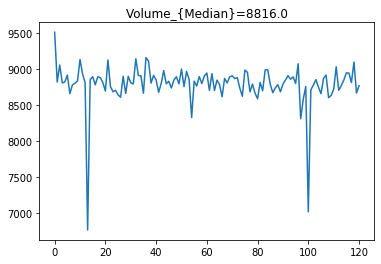

In [149]:
from skimage import segmentation
labeled = label( segmentation.clear_border(cleaned) )
allBeads = ndi.find_objects(labeled)
nobjects = np.max(labeled)
accum = np.zeros(nobjects)
for i in np.arange(nobjects):
    loc = allBeads[i]
    bead = binary[loc]
    accum[i-1] = np.sum(bead)
plt.plot(accum)
plt.title('Median Volume on Eroded stack='+str(np.median(accum)))

In [150]:
np.sum(binary) / 8816

214.32509074410163

# Visualizing stacks with itkwidgets
- Visualize 2D and 3D images, point sets, and geometry, e.g. meshes, in Jupyter
- Support for NumPy array images, itk.Image, Dask array images and more
- More info at [[repo]](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [88]:
#Tip: slide right to see different labeled object
import itk
from itkwidgets import view

#original img
image_itk = itk.GetImageFromArray(img.astype('uint8'))
#view(image_itk, slicing_planes=True, gradient_opacity=0)

In [89]:
#cleaned
image_itk = itk.GetImageFromArray(labeled.astype('uint8'))
#view(image_itk, slicing_planes=True, gradient_opacity=0)

In [ ]:
#a bead
view(itk.GetImageFromArray(bead.astype('uint8')))

## Downsample for images > 1M voxels

In [151]:
#Quick view of content
downsample = 3 #isotropic downsampling
image_np=binary[::downsample,::downsample,::downsample]
image_itk = itk.GetImageFromArray(image_np.astype(np.int16))
#view(image_itk, gradient_opacity=0.4)

## Anisotropic volumes

In [97]:
new_spacing = [4, 1, 1]
image_itk.SetSpacing(new_spacing)
#view(image_itk, cmap='Blues', gradient_opacity=0.4)

Viewer(cmap='Blues', geometries=[], gradient_opacity=0.4, point_sets=[], rendered_image=<itkImagePython.itkIma…

In general, there's some much one can segment using only classical filters and thresholding. A complete investigation will often include machine learning methods using unsupervised and supervised classification of voxels.

## Euclidean distance transform

In [ ]:
from scipy import ndimage as ndi
edt = ndi.distance_transform_edt(binary)

In [ ]:
slicing(edt)

## Creating markers

In [ ]:
from skimage import feature
seeds = feature.peak_local_max(edt,indices = False,footprint=np.ones((3, 3, 3)),
                            labels=binary) #return sparse matrix instead of array with peaks

In [ ]:
markers = ndi.label(seeds)[0]
labels = morphology.watershed(-edt, markers, mask=binary)
print(np.max(markers))

In [ ]:
b = morphology.binary_dilation(markers, selem=aball)
slicing(b)

In [ ]:
np.shape(seeds)

In [ ]:
from scipy import ndimage as ndi
seeds = ndi.label(binary)[0]
ws = morphology.watershed(a, seeds)

In [ ]:
import itk
from itkwidgets import view

image_itk = itk.GetImageFromArray(labels.astype(np.uint8))
#view(image_itk, cmap='Cold and Hot', rotate=True, gradient_opacity=0.4)

# Beyond thresholding

## Supervised classification using markers

In [ ]:
from skimage import segmentation as seg
b = bilat[n,:,:]
plt.imshow(b)
plt.grid()

In [ ]:
seed_point = (25, 30)  # Experiment with the seed point
c = seg.flood(b, seed_point, tolerance=40)
plt.imshow(c)

## Unsupervised - kmeans

In [ ]:
from skimage.segmentation import slic, mark_boundaries
from skimage import restoration
segments = slic(b, n_segments=250, compactness=0.05, enforce_connectivity=True, sigma=10, max_iter=500, multichannel=False) #higher compact = more weight space, more square
plt.imshow(mark_boundaries(b, segments))

In [ ]:
np.shape(segments)

In [ ]:
from skimage import color
from skimage.future import graph
output = color.label2rgb(segments, aslice, kind='avg')
plt.imshow(output,cmap='gray')

In [ ]:
from scipy import ndimage as ndi


segments = slic(bilat, n_segments=250, compactness=0.05, enforce_connectivity=True, sigma=10, max_iter=50, multichannel=False) #higher compact = more weight space, more square
output = color.label2rgb(segments, volFilt, kind='avg')

In [ ]:
slicing(output)

In [ ]:
from skimage import img_as_ubyte
o = img_as_ubyte(output)
view(o, slicing_planes=True,gradient_opacity=0.4)

In [ ]:
from skimage import feature, measure

In [ ]:
label = measure.label(binary)
regions = measure.regionprops(label,intensity_image=img)

In [ ]:
np.max(label) #len(regionprops)

In [ ]:
#all_props = {p:regions[0][p] for p in regions[0] if p not in ('image','convex_image','filled_image')}
for p in regions:
    print(p.area)

In [ ]:
image_itk = itk.GetImageFromArray(label.astype(np.uint16))
view(image_itk, cmap='Cold and Hot', slicing_planes=True,gradient_opacity=0.4)